# Sensitivity of sequana_coverage in detecting CNVs

    Author: Thomas Cokelaer
    Jan 2018
    Local time execution: about 10  minutes

# Requirements

- sequana version 0.6.5 was used
- art_illumina

In [1]:
%pylab inline
rcParams['figure.figsize'] = (10,7)

Populating the interactive namespace from numpy and matplotlib


# Get the reference 

There are many ways to download the reference (FN433596). Here below we use sequana_coverage tool but of course, you can use your own tool, or simply go to http://github.com/sequana/resources/coverage (look for FN433596.fasta.bz2).

In [1]:
!sequana_coverage --download-reference FN433596

INFO    [sequana]:  Downloading reference FN433596 from ENA



# Simulated FastQ data 

Simulation of data coverage 100X

```
-l: length of the reads
-f: coverage
-m: mean size of fragments
-s: standard deviation of fragment size
-ss: type of hiseq
```
This taks a few minutes to produce 

In [3]:
import subprocess
for DP in [200, 100, 80, 60, 40, 20, 10]:
    print(DP)
    # Creating the simulated data with expected depth of coverage
    cmd = "art_illumina -sam -i FN433596.fa -p -l 100 -ss HS20 -f 20 -m 500 -s 40 -o paired_dat -f {}"
    cmd = cmd.format(DP)
    subprocess.call(cmd.split())
    
    # Creating the BAM files (deletes previous ones)
    # This command uses bwa and samtools behind the scene. 
    cmd = "sequana_mapping --reference FN433596.fa --file1 paired_dat1.fq --file2 paired_dat2.fq"
    subprocess.call(cmd.split())
    
    # creating the BED file once for all
    # Here, we use bioconvert (http://bioconvert.readthedocs.io) that uses bedtools behind the scene.
    cmd = "bioconvert FN433596.fa.sorted.bam simulated_{}X.bed -f".format(DP)
    subprocess.call(cmd.split())
    

400
200
100
80
60
40
20
10


# Impact of the window parameter on the normalised coverage distribution (100X case)

In [4]:
from sequana import *
b = GenomeCov("simulated_100X.bed")
c = b.chr_list[0]

Let us run the running median / normalisation / zscore computation using several window parameter (e.g 20001, 80001...)

In [5]:
c.run(20001, circular=True)
data20000 = c.df['cov'] / c.df['rm']

In [6]:
c.run(10001, circular=True)
data10000 = c.df['cov'] / c.df['rm']

In [7]:
c.run(40001, circular=True)
data40000 = c.df['cov'] / c.df['rm']

c.run(2001, circular=True)
data2000 = c.df['cov'] / c.df['rm']

c.run(80001, circular=True)
data80000 = c.df['cov'] / c.df['rm']


Window parameter does not seem to have any impact on the distribution of the normalised coverage, which is centered around 1 and same standard deviation.

Text(0.5,0,'normalised coverage')

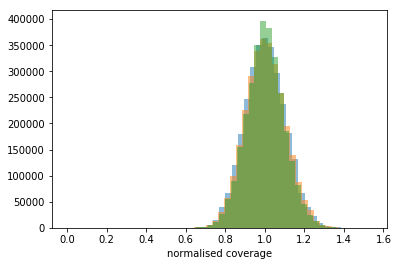

In [8]:
#_ = hist(data20000, bins=50, alpha=0.5)
_ = hist(data40000, bins=50, alpha=0.5)
_ = hist(data80000, bins=50, alpha=0.5)
_ = hist(data2000, bins=50, alpha=0.5)
xlabel("normalised coverage")

[]

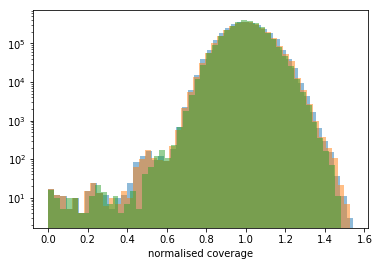

In [9]:
#_ = hist(data20000, bins=50, alpha=0.5)
_ = hist(data40000, bins=50, alpha=0.5)
_ = hist(data80000, bins=50, alpha=0.5)
_ = hist(data2000, bins=50, alpha=0.5)
xlabel("normalised coverage")
semilogy()

Note that if we look at the distribution on a log scale (on Y axis), the distributions are not Gaussian. This is because the mapped data exhibits a mix of distributions. However, the central distribution looks gaussian.
Switching to a logy scale and superimposing a normal distribution should convince the reader that this statement is true.
    
    


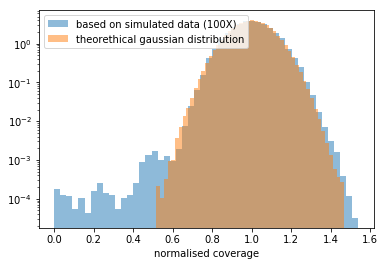

In [10]:
_ = hist(data40000, bins=50, alpha=0.5, normed=True, label="based on simulated data (100X)")
xlabel("normalised coverage")
semilogy()

datanorm = [normal()/10+1 for x in range(1000000)]
_ = hist(datanorm, bins=50, alpha=0.5, normed=True, label="theorethical gaussian distribution")
legend()

For lower DOC, the gaussian distribution assumption is not True anymore. You have skewed distribution. Events below the mean DOC may be missed. Events above the lean DOC may be over detected. This means that the thresholds should be ajusted. For isntance instead of the default pair (-4,4), one could use (-4, 6).

(9.1498064917581843e-06, 10)

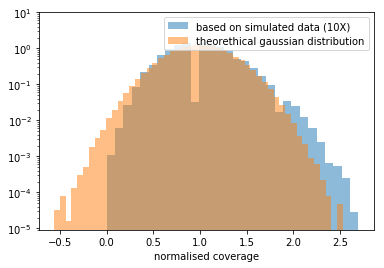

In [11]:
from sequana import *
b = GenomeCov("simulated_10X.bed")
c = b.chr_list[0]
c.run(20001, circular=True)
data = c.df["cov"]/c.df['rm']
_ = hist(data, bins=30, alpha=0.5, normed=True, label="based on simulated data (10X)")
xlabel("normalised coverage")
semilogy()

datanorm = [normal()/sqrt(10)+1 for x in range(1000000)]
_ = hist(datanorm, bins=50, alpha=0.5, normed=True, label="theorethical gaussian distribution")
legend()
ylim([ylim()[0], 10])

# Impact of DOC on the normalised distribution standard deviation

In [47]:
DOC =   [4,    6,    8,    10,   20,    40,     60,     80,    100,    200,]
STDs =  [2,    2.44, 2.82, 3.17, 4.46,  6.31,   7.76,   8.95,  10.08,  14.27]
CVs =   [0.5,  0.41, 0.35, 0.32, 0.22,  0.16,   0.13,   0.11,  0.10,   0.07]
stds =  [0.51, 0.41, 0.35, 0.32, 0.225, 0.158,  0.129,  0.111, 0.10,   0.07]

To obtain the number above, you can use the following function. Note that DOC is depth of coverage, STDs is the standard deviation of the genome coverage. CVs is the coefficient of variation and stds is the standard deviation of the normalized genome coverage. 

In [13]:
def get_metrics(DOC):
    b = GenomeCov("simulated_{}X.bed".format(DOC))
    c = b.chr_list[0]
    c.run(20001, circular=True)
    normed = c.df['cov']/c.df['rm']
    DOC = c.df['cov'].mean()
    STD = c.df['cov'].std()
    return DOC, STD, STD/DOC , std(normed)
    

In [14]:
get_metrics(20)

(19.997248300314471,
 4.4771620261326399,
 0.2238889050581141,
 0.22535014440593723)

We can see that the standard distribution of the normalised coverage is equal to the coefficient of variation (CV) of the original coverage:
    
$ \frac{\sigma(coverage)}{DOC(coverage)} = CV(coverage)$

where CV stands for coefficient of variation

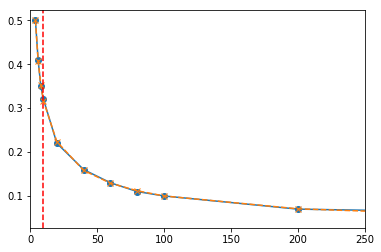

In [15]:
plot(DOC, CVs, "o-")
plot(DOC, 1/np.array(DOC)**0.5, "x--")
xlim([0,250])
axvline(10, color="r", ls="--")


# Distribution of the running median

The distribution of the running median vector is centered around the mean
of the genome coverage. The standard deviation decreases with increasing W.

In [5]:
def get_rm_metrics(DOC, W):
    b = GenomeCov("simulated_{}X.bed".format(DOC))
    c = b.chr_list[0]
    c.run(W, circular=True)
    return c.df.copy()

In [63]:
df100 = get_rm_metrics(100, 100)
df1000 = get_rm_metrics(100, 1000)
df10000 = get_rm_metrics(100, 10000)
df100000 = get_rm_metrics(100, 100000)

(60, 140)

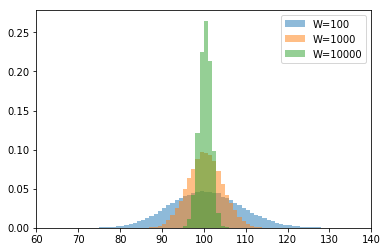

In [77]:
_ = hist(df100['rm'], normed=True, bins=range(150), alpha=0.5)
_ = hist(df1000['rm'], normed=True, bins=range(150), alpha=0.5)
_ = hist(df10000['rm'], normed=True, bins=range(150), alpha=0.5)
#_ = hist(df100000['rm'], normed=True, bins=range(150), alpha=0.5)
legend(["W=100", "W=1000", "W=10000", "W=100,000"])
xlim([60,140])

For very large W, the distribution standard deviation tend to be small and more importantly discrete.

(80, 140)

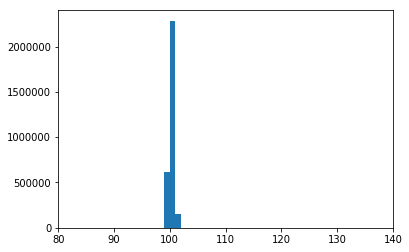

In [82]:
_ = hist(df100000['rm'], bins=range(150))
xlim([80,140])